## Principal Component Pursuit (PCP)

PCP algorithm is a robust Principal Component Analysis technique that allows to interpret large data that contains sparsity. In a sense, it allows one to capture outliers in a dataset or corrupted date by splitting the data into a foreground + background in order capture the relevant information in a robust way. 

Sources: https://arxiv.org/abs/0912.3599 and https://www.mins.ee.ethz.ch/pubs/files/realtimePCP.pdf

### Background and Motivation

Suppose we are given a large data matrix M, and know that it may be decomposed as

$$ M = L_0 + S_0 $$

where $L_0$ has low-rank and $S_0$ is sparse; here, both components are of arbitrary magnitude. We do not know the low-dimensional column and row space of $L_0$, not even their dimension. Similarly, we do not know the locations of the nonzero entries of $S_0$, not even how many there are. Can we hope to recover the low-rank and sparse components both accurately (perhaps even exactly) and efficiently?

A provably correct and scalable solution to the above problem would presumably have an impact on today’s data-intensive scientific discovery. The recent explosion of massive amounts of high-dimensional data in science, engineering, and society presents a challenge as well as an opportunity to many areas such as image, video, multimedia processing, web relevancy data analysis, search, biomedical imaging and bioinformatics. In such application domains, data now routinely lie in thousands or even billions of dimensions, with a number of samples sometimes of the same order of magnitude.

However, often such data have low intrinsic dimensionality, e.g. that they lie on some low-dimensional subspace, are sparse in some basis, or lie on some low-dimensional manifold. Perhaps the simplest and most useful assumption is that the data all lie near some low-dimensional subspace. More precisely, this says that if we stack all the data points as column vectors of a matrix $M$, the matrix should have (approximately) low-rank: mathematically,

$$ M = L_0 + N_0$$

where $L_0$ has low-rank and $N_0$ is a small perturbation matrix. Classical [Principal Component
Analysis (PCA)](https://www.youtube.com/watch?v=fkf4IBRSeEc) seeks the best rank-k estimate of $L_0$ by solving

$$ \textrm{minimize}\quad || M-L || \quad \textrm{subject to}\quad \textrm{rank}(L)\leq k$$

where $||M||$ is the two norm of the matrix M, corresponding to the largest singular value of M. This problem can be efficiently solved via the singular value decomposition (SVD) and enjoys a number of optimality properties when the noise $N_0$ is small and i.i.d. Gaussian.

### A Robust PCA: PCP

PCA is arguably the most widely used statistical tool for data analysis and dimensionality reduction today. However, "largely" corrupted data (observations) often renders this approach invalid  – a single grossly corrupted entry in $M$ could render the estimated $L$ arbitrarily far from the true $L_0$. Unfortunately, gross errors are now ubiquitous in modern applications such as image processing, web data analysis, and bioinformatics, where some measurements may be arbitrarily corrupted (due to occlusions, malicious tampering, or sensor failures) or simply irrelevant to the low-dimensional structure we seek to identify. 

PCP algorithm we introduce in this notebook aims to recover a low-rank matrix $L_0$ from highly corrupted measurements $M = L_0 +S_0$. Unlike the small noise term $N_0$ in classical PCA, the entries in $S_0$ can have arbitrarily large magnitude, and their support is assumed to be sparse but unknown. See e.g https://arxiv.org/abs/0912.3599 for possible applications of PCP. 

### PCP Algorithm

Let $M = L + S$ be a $n_1 \times n_2$ matrix, given as a sum of low-rank $L$ and a sparse matrix $S$ with a small fraction of non-zero entries. PCP algorithm aims to obtain $L$ and $S$ by solving the following optimization problem

$$ \textrm{PCP:}\quad \textrm{minimize:}\quad ||L||_* + \lambda ||S||_1\quad \textrm{subject to}\quad L+S = M $$

where $||A||_* = \sum_i \sigma_i(A)$ (with $\sigma_i$ is the $i$th singular value of the matrix A) is the nuclear form of a matrix $A$ and $||A||_1 = \sum_{i,j} |A|_{ij}$ is its $l_1$ (1-) norm. In the expression above, $\lambda$ parameter represents the tradeoff between rank and sparsity. Intuitively, PCP is related to the problem of
decomposing $M$ into $L$ and $S$, because the 1-norm enforces sparsity in S and the nuclear norm enforces low rank in L.

One effective way to solve PCP for the case of large matrices is to use a standard augmented Lagrangian multiplier
method which consists of defining the augmented Lagrangian function:

$$ l(L,S,Y) = ||L||_* + \lambda ||S||_1 + \langle Y, M-L-S\rangle + \mu ||M - L -S||^2_F$$ 

and then minimizing it iteratively by setting 

$$ (L^{(k)},S^{(k)}) = \textrm{arg min}_{L,S}\,\, l(L,S,Y^{(k)})$$

and updating $Y^{(k+1)} = Y^{(k)} + \mu (M - L^{(k)}-S^{(k)})$ at each iteration. The matrix $Y$ contains lagrange multipliers, and the parameter $\mu > 0$ is a tuning parameter that determines the convergence of the algorithm. As noted in the sources we use for this notebook, one can actually take an alternative approach using optimization by alternating directions enabled by the fact that optimization at each direction $L/S$ (keeping one fixed) takes simple closed forms

$$ \textrm{arg min}_{L}\,\, l(L,S,Y) = \mathcal{D}_{\mu^{-1}}(M-S+\mu^{-1}Y) \quad\quad \textrm{arg min}_{S}\,\, l(L,S,Y) = \mathcal{S}_{\lambda \mu^{-1}}(M-L+\mu^{-1}Y) $$

so that we can replace one optimization problem with two presented in the expression above. In the relations above, $\mathcal{S}_\tau(x) = {\rm sign}(x)\, {\rm max}(|x|-\tau,0) $ is the shrinkage operator and we define the singular value shrinkage operator as $D_\tau(A) = U \mathcal{S}_\tau (\Sigma) V^{T} $ where $A = U \Sigma V^T$ is the [singular value decomposition (SVD)](https://www.youtube.com/watch?v=nbBvuuNVfco) of the matrix A. 

As suggested by  https://arxiv.org/abs/0912.3599, we will take 

$$\mu = \frac{n_1 n_2}{4 ||M||_1},\quad\quad\quad\quad \lambda = \frac{1}{\sqrt{{\rm max}(n_1,n_2)}}$$

The correct implementation (as compared to https://arxiv.org/abs/0912.3599) of the PCP algorithm that summarizes the lines above is given in Algorithm 1 of https://www.mins.ee.ethz.ch/pubs/files/realtimePCP.pdf 

### An application of PCP: Electricity Prices in the Power Market

#### Problem: 
Electricity prices tend to vary smoothly in response to supply and demand signals, but are subject to intermittent price spikes that deviate substantially from normal behaviour.

Forming the price data from one commerical trading hub into a matrix $M$ with each day as a row and each hour as a column, we can consider $M$ as the combination of a low-rank matrix $L$ consisting of the normal daily market behaviour, and a sparse matrix $S$ consisting of the intermittent price spikes. Given the price data $M$, we would like to obtain $L$ and $S$ using the PCP algorithm.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

# For inline plotting 

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Plot parameters defined globally
mpl.rcParams['text.usetex'] = True

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [4]:
data = pd.read_csv("TS_Electricity.csv", index_col=0, parse_dates=True)

data.head()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
2018-01-01,31.97,30.64,29.16,29.72,30.23,35.94,46.08,79.75,59.58,78.29,...,34.61,32.06,37.48,112.02,233.77,114.29,60.57,68.79,46.55,41.63
2018-01-02,48.28,36.28,49.24,42.16,42.87,39.58,44.61,116.85,73.34,124.47,...,37.09,33.89,38.76,112.23,294.99,120.33,125.64,54.80,78.83,41.02
2018-01-03,43.73,40.48,39.85,34.98,43.85,52.47,44.38,58.64,58.91,65.21,...,54.64,51.23,51.11,62.24,82.22,84.20,76.81,80.72,71.78,62.42
2018-01-04,125.69,66.86,64.90,64.05,95.66,56.92,109.05,101.21,101.76,77.43,...,58.54,54.03,53.28,58.68,76.28,83.94,79.71,82.71,77.10,64.69
2018-01-05,51.05,48.68,48.08,47.83,48.56,52.30,54.11,63.86,90.20,76.22,...,20.63,-17.77,10.34,30.12,34.85,39.85,51.40,44.13,45.45,41.96


(244, 24)


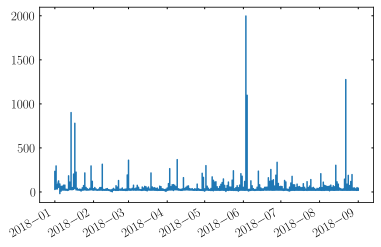

In [5]:
# Unroll the daily values to plot the timeseries. Note the spikes we wish to separate.
timeseries = data.stack()
timeseries.index = timeseries.index.droplevel(1) # Drop extra numbering label of data 1-24,25-... when you unroll

plt.rcParams['text.usetex'] = True

plt.tick_params(axis='both', direction="in", labelsize = 13, top= 'bool', right= 'bool')
plt.tick_params(axis="both", which='minor', direction='in',top= 'bool', right= 'bool')

timeseries.plot()

M = data.values
print(M.shape)

In [9]:
# 244 * 24 hours of data 
m,n = M.shape
hours_of_data = m*n
print("Total number of hours in the data: ", hours_of_data)

Total number of hours in the data:  5856


In [10]:
# First define the shrinkage operator

def shrink(X, tau):
    return np.sign(X) * np.maximum(np.abs(X) - tau,0)

In [19]:
def PCPAD(MX, lamb, mu, num_iter = 200, stop_c = 10**(-7)):
    
    n1, n2 = MX.shape # shape of the input matrix, n1 rows and n2 coloumns 
    
    #L = np.zeros((n1,n2))
    S = np.zeros((n1,n2))
    Y = np.zeros((n1,n2)) #Lagrange multiplier matrix that works like an auxiliary regulator
    
    count = 0 # counter for iterations
    
    while count < num_iter:
        
        count += 1
        
        # SVD decomposition of M - S_k - (1/mu) * Y_k, Sig is a 1D array, i.e a vector
        
        U, Sig, Vs = np.linalg.svd(MX - S + (1/mu)*Y, full_matrices = False) 
        
        # Update low-rank L according to formula at page 29
        
        L = U @ np.diag(shrink(Sig, 1/mu)) @ Vs
        
        # Update Sparse matrix 
        
        S = shrink(MX - L + (1/mu)*Y, lamb/mu)
        
        # update Y 
        
        Y += mu * (MX - L - S)
        
        # check convergence 
        
        if np.linalg.norm(MX - L - S, 'fro')/np.linalg.norm(MX, 'fro') < stop_c:
            break
    
    return L, S

In [20]:
# before obtaining results we need mu and lambda and for that lets define one-norm of a Matrix

def onenorm(m):
    return np.sum(np.abs(m))

n1, n2 = M.shape

mu = n1*n2/(4 * onenorm(M))

lambd = 1/(np.sqrt(np.maximum(244,24)))

In [21]:
# Extract the results 

L, S = PCPAD(M, lambd, mu)

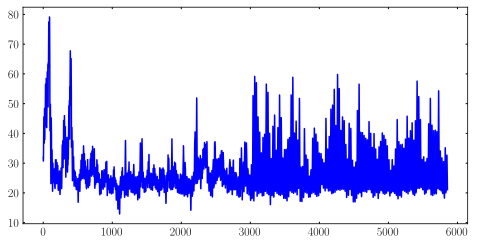

In [28]:
plt.figure(figsize = (8,4))
plt.plot(L.flatten(), color = 'blue')

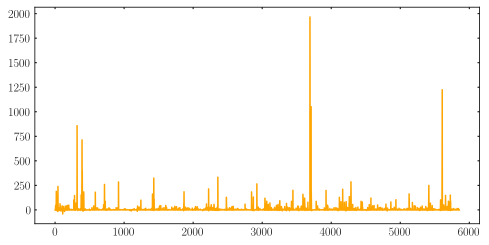

In [29]:
plt.figure(figsize = (8,4))
plt.plot(S.flatten(), color = 'orange')